# Set up environment paths

In [2]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

RAW_DIR = os.path.join(os.getcwd(), "data", "raw")
print(f"The raw data is located in the directory:\n{RAW_DIR}.")
BINNED_DIR = os.path.join(os.getcwd(), "data", "binned")
print(f"The binned data is located in the directory:\n{BINNED_DIR}.")

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The raw data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned.


# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Inspect Raw Data

In [4]:
import neuralgeom.datasets.utils as utils

expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

INFO: Using pytorch backend


In [5]:
metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [6]:
n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} cells/units/clusters recorded in this experiment.")

There are 40 cells/units/clusters recorded in this experiment.


## Define experimental variables

- startTs: 

- stopTs:

- encTimes:

- encAngle:

- supepochs:

- landAngle:

- gain:

- vel:

- relAngle:

- landOffTime:

- landOffAngle:

- landOffIdx:

- estGain:

- hippAngle:

# Load neural activity + measured lab variables ("labels")

In [7]:
import neuralgeom.datasets.experimental as experimental

expt_id = "34"
timestep_microseconds = int(1e6)

neural_activity, labels = experimental.load_neural_activity(expt_id=expt_id, timestep_microsec=timestep_microseconds)

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

print(f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps")

INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_neural_activity_timestep1000000.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep1000000.txt! Loading...


There are 40 neurons binned over 2953 timesteps


Visualize activity over time (PSTH) -- no speed thresholding

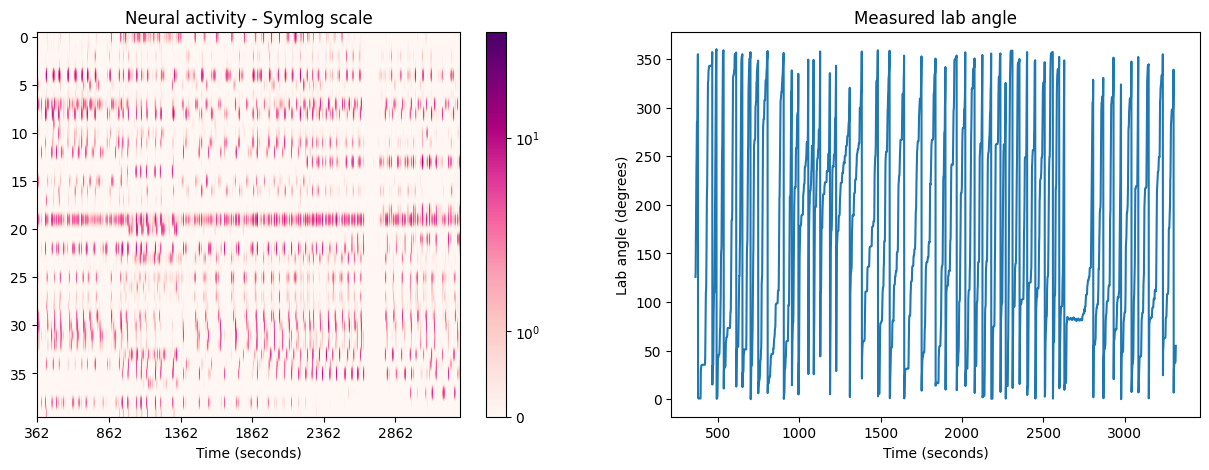

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

psth = axs[0].imshow(neural_activity.T, aspect="auto",cmap="RdPu",norm="symlog")
axs[0].set_title("Neural activity - Symlog scale")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::500])
axs[0].set_xticklabels(times_in_seconds[::500].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth,ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")
axs[1].set_title("Measured lab angle");

Apply threshold speed = 5 cm/s (place cell activity occurs when rat in motion)

In [9]:
neural_activity = neural_activity[labels["velocities"]>5]

labels = labels[labels["velocities"]>5]
print(f"There are {neural_activity.shape[0]} timesteps where the rat's speed was greater than 5 cm/s")

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

There are 934 timesteps where the rat's speed was greater than 5 cm/s


Visualize activity vs angles ("Peristimulus Angle Histogram")

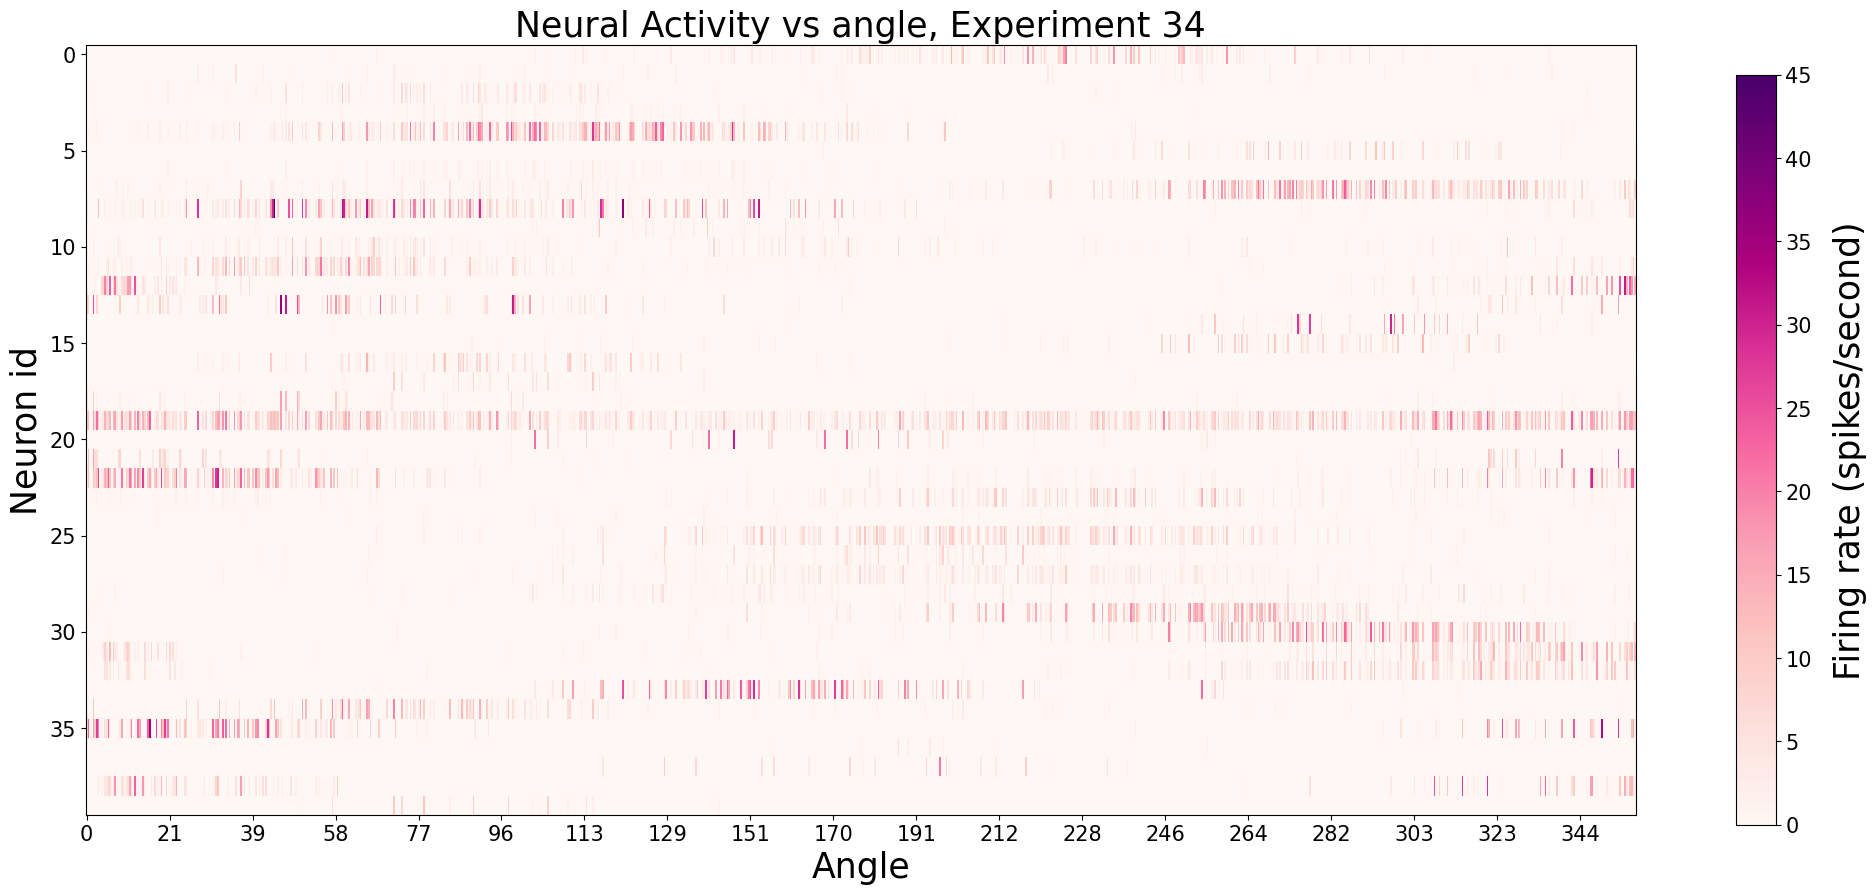

In [10]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]
fig, axs = plt.subplots(figsize=(20, 10))
psah = axs.imshow(sorted_neural_activity.T, aspect="auto",cmap="RdPu",interpolation="none")
axs.set_title(f"Neural Activity vs angle, Experiment {expt_id}",fontsize=25)
axs.set_xticks(np.arange(len(sorted_angles))[::50])
axs.set_xticklabels(sorted_angles[::50].astype(int))
axs.set_xlabel("Angle",fontsize=25)
axs.set_ylabel("Neuron id",fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=15)


cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])


cbar = fig.colorbar(psah, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## Option: smooth binned data

### Smooth wrt time

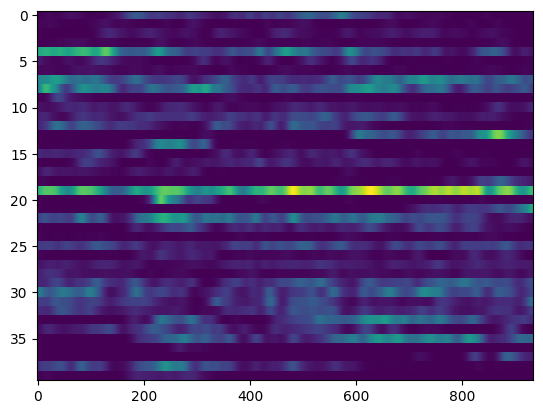

In [11]:
from scipy.ndimage.filters import gaussian_filter1d

# Apply the Gaussian filter to smooth the spike train
# 'sigma' is the standard deviation of the Gaussian kernel, in units of time bins
sigma = 10
smoothed_neural_activity = gaussian_filter1d(neural_activity.astype(float),sigma, axis=0)

plt.imshow(smoothed_neural_activity.T,aspect="auto",interpolation="none")

### Smooth wrt angle

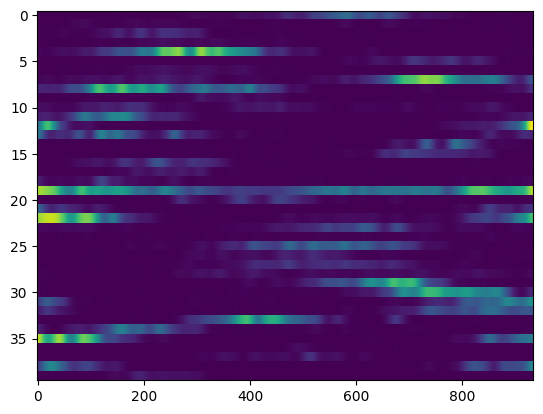

In [12]:
from scipy.ndimage.filters import gaussian_filter1d

# Apply the Gaussian filter to smooth the spike train
# 'sigma' is the standard deviation of the Gaussian kernel, in units of time bins
sigma = 10
smoothed_sorted_neural_activity = gaussian_filter1d(sorted_neural_activity.astype(float),sigma, axis=0)

plt.imshow(smoothed_sorted_neural_activity.T,aspect="auto",interpolation="none")

## Isolate "canonical" place cells

Calculate Mutual Information between angular position and activity for each neuron

!!!!!TODO!!!!!: 

account for topology of angular variable. Maybe turn $\theta$ -> $(\cos{\theta},\sin{\theta})$ and use multivariate MI? 

What are other tests of independence/ correlation coefficiens?

See:
- https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
- https://arxiv.org/pdf/1307.7383.pdf
- https://arxiv.org/pdf/1909.10140.pdf
- https://github.com/minepy/mictools

### Mutual Information between position $\theta$ and neural activity

In [13]:
from sklearn.feature_selection import mutual_info_regression

angles_radians=angles*np.pi/180

spatial_mutual_info = mutual_info_regression(neural_activity,angles_radians)

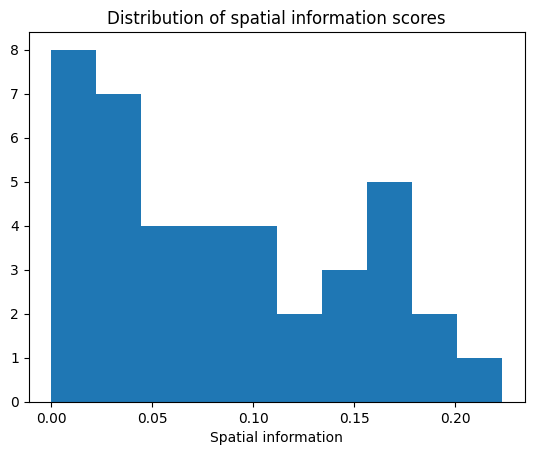

In [51]:
hist = plt.hist(spatial_mutual_info)
plt.xlabel("Spatial information")
plt.title("Distribution of spatial information scores");

Set a MI threshold

In [15]:
threshold = 0.1

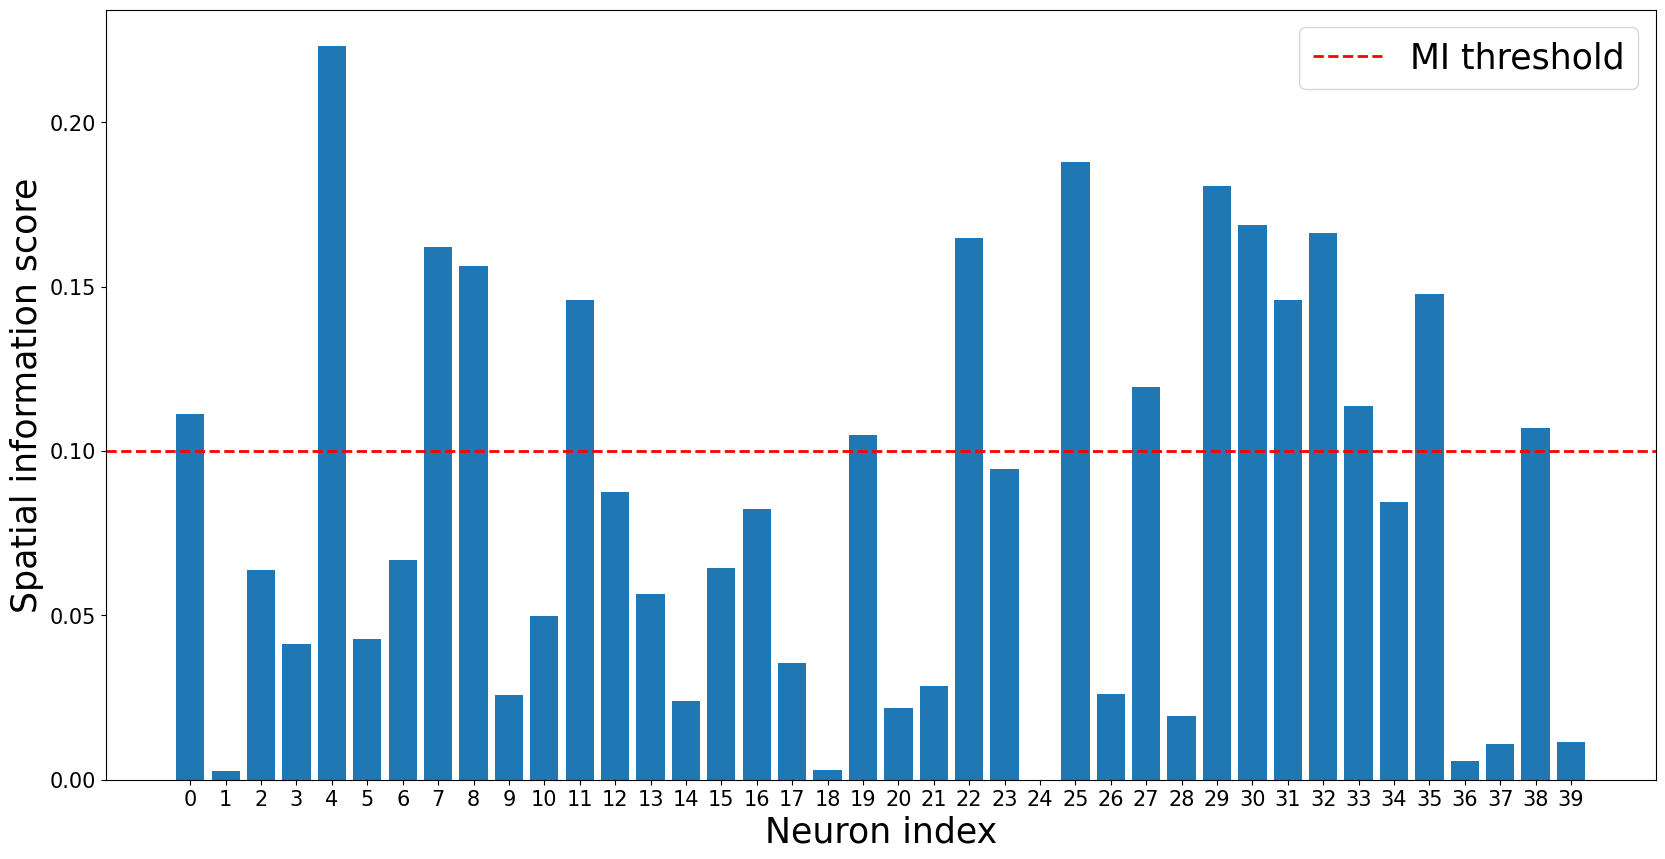

In [16]:
x_ticks = np.arange(0,len(spatial_mutual_info))

fig, ax = plt.subplots(figsize=(20,10))

# Plot the barograph
ax.bar(x_ticks, spatial_mutual_info)

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks);
ax.set_xlabel("Neuron index",fontsize=25)
ax.set_ylabel("Spatial information score",fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")
ax.legend(fontsize=25);

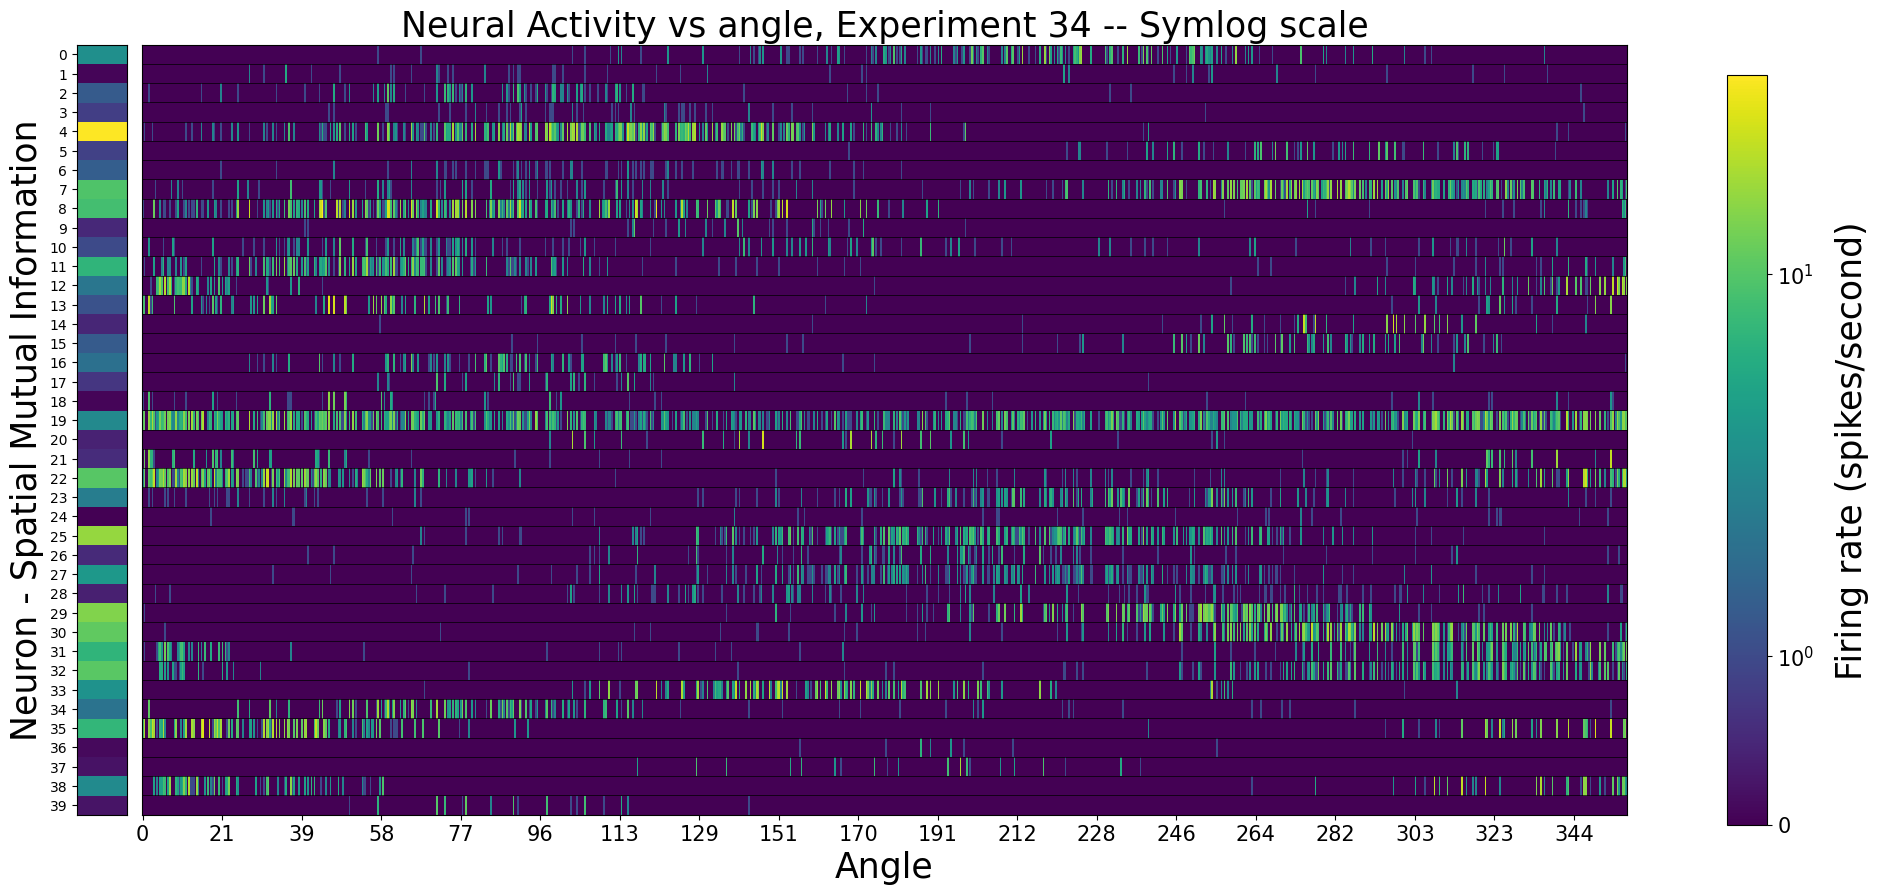

In [39]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = spatial_mutual_info

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(sorted_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

Visualize PSAH for neurons with high spatial information

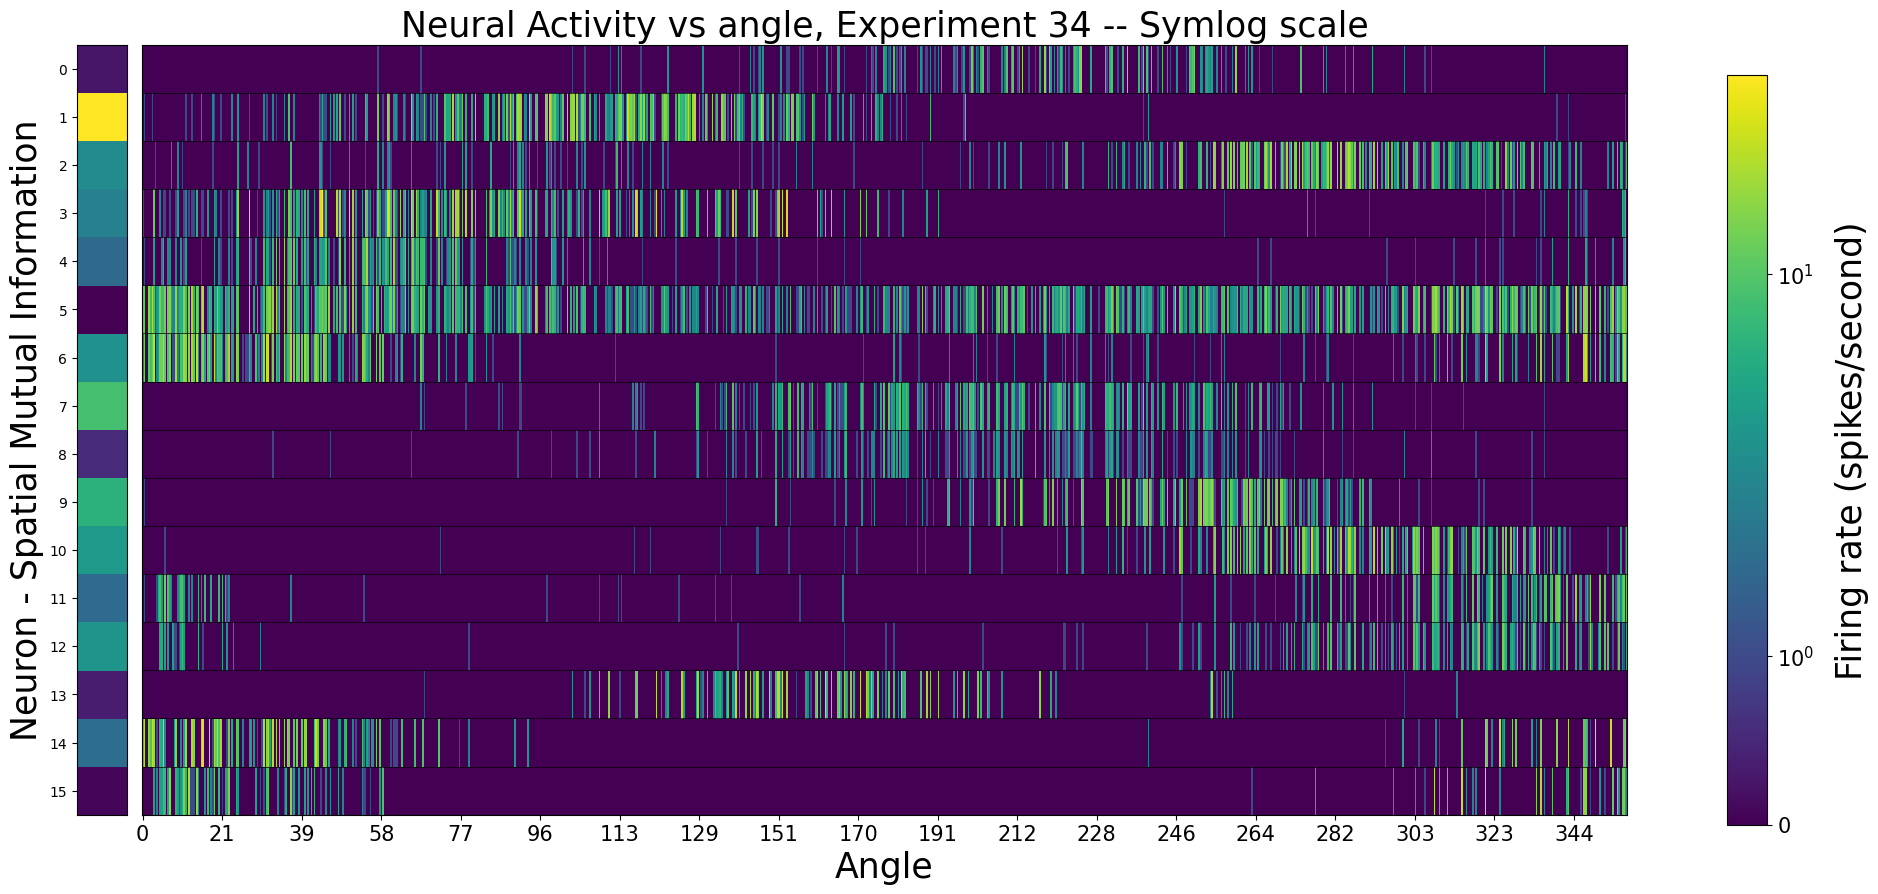

In [63]:
mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info>threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info[spatial_mutual_info>threshold]

sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = mi_thresh_spatial_mutual_info

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(mi_thresh_spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(sorted_mi_thresh_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_mi_thresh_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

### Mutual information between neural activity and $\cos{\theta}$, $\sin{\theta}$

In [66]:
angles_radians = angles*np.pi/180

X = np.cos(angles_radians)
Y = np.sin(angles_radians)

spatial_mutual_info_X = mutual_info_regression(neural_activity,X)
spatial_mutual_info_Y = mutual_info_regression(neural_activity,Y)
spatial_mutual_info_XY = spatial_mutual_info_X + spatial_mutual_info_Y

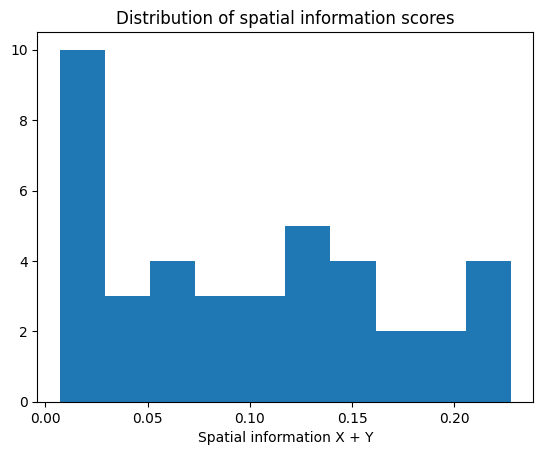

In [67]:
plt.hist(spatial_mutual_info_XY)
plt.xlabel("Spatial information X + Y")
plt.title("Distribution of spatial information scores");

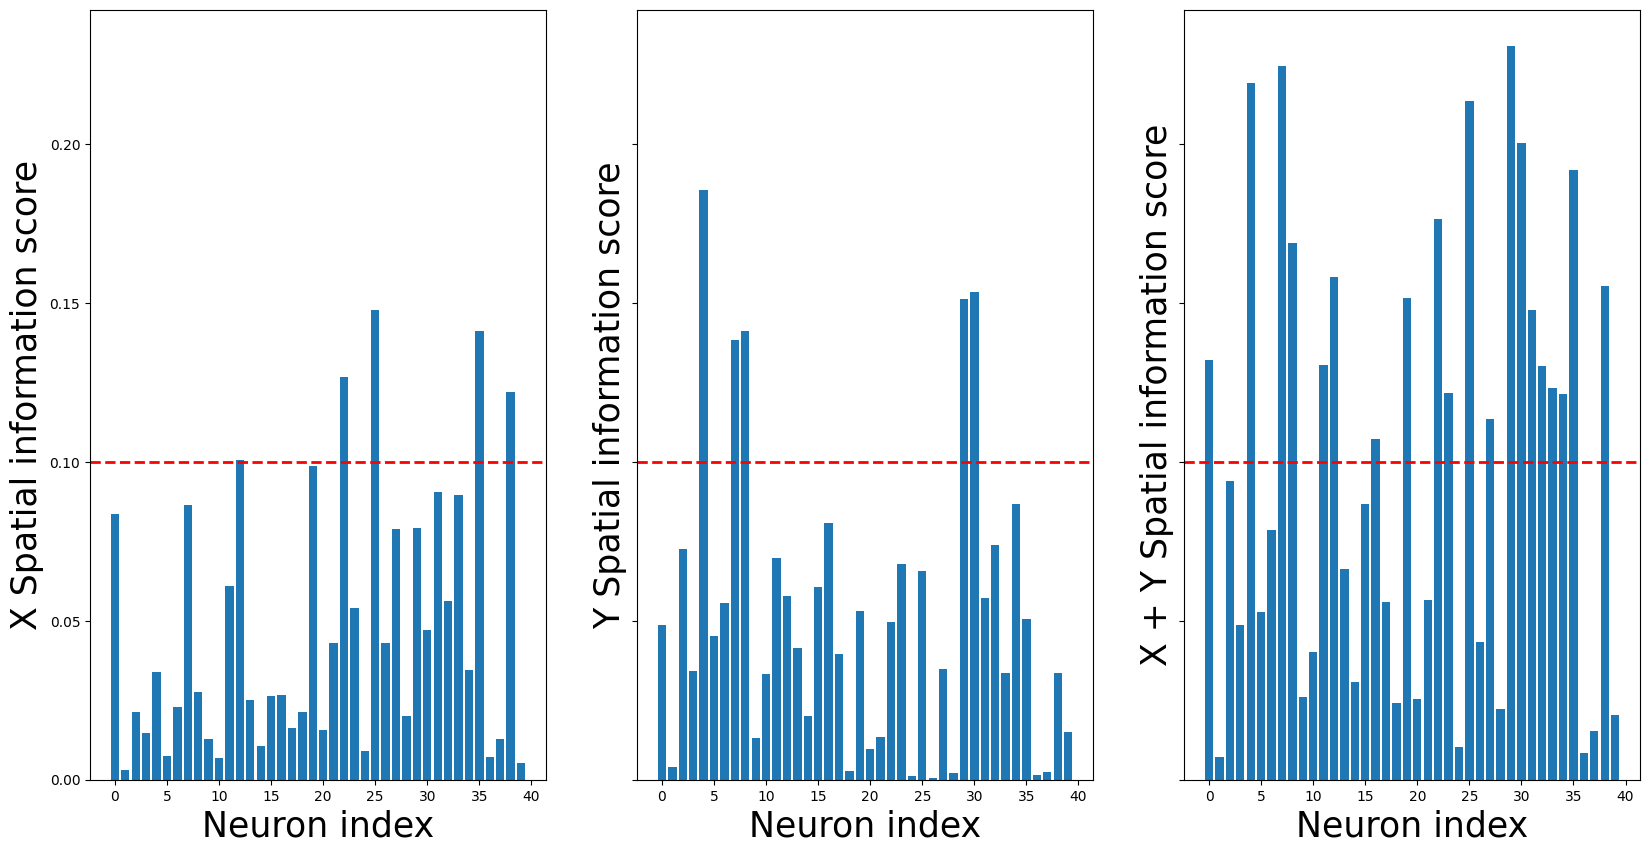

In [53]:
fig, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)
axs[0].bar(x_ticks, spatial_mutual_info_X)
axs[0].set_xlabel("Neuron index",fontsize=25)
axs[0].set_ylabel("X Spatial information score",fontsize=25)
axs[0].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")

axs[1].bar(x_ticks, spatial_mutual_info_Y)
axs[1].set_xlabel("Neuron index",fontsize=25)
axs[1].set_ylabel("Y Spatial information score",fontsize=25)
axs[1].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold")

axs[2].bar(x_ticks, spatial_mutual_info_XY)
axs[2].set_xlabel("Neuron index",fontsize=25)
axs[2].set_ylabel("X + Y Spatial information score",fontsize=25)
axs[2].axhline(threshold, color='red', lw=2, linestyle='--',label="MI threshold");

Set Spatial Mutual Information threshold

In [68]:
mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info_XY>threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info_XY[spatial_mutual_info_XY>threshold]

Visualize PSAH for neurons with high spatial information

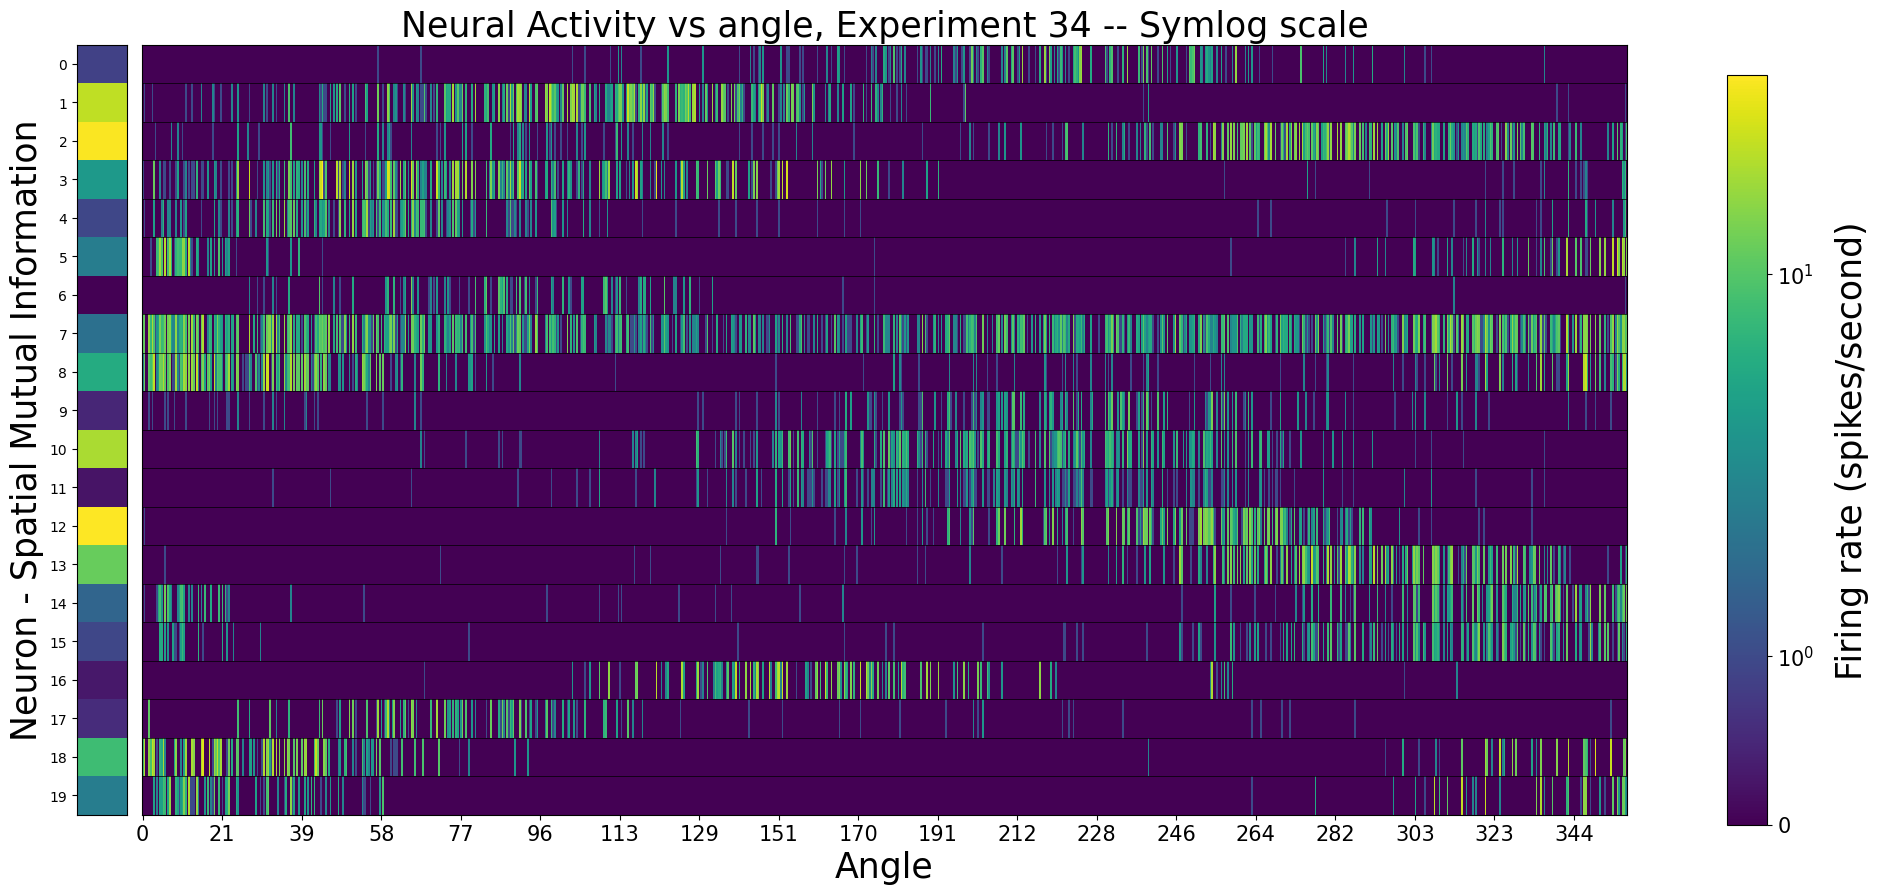

In [69]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = mi_thresh_spatial_mutual_info

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(mi_thresh_spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(sorted_mi_thresh_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_mi_thresh_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

### Organize neurons according to place field center of mass + visualize

In [70]:
weights = sorted_mi_thresh_neural_activity.T

points = np.tile(sorted_angles,(weights.shape[0], 1))

weighted_center_of_mass = np.average(points, weights=weights, axis=1)

center_of_mass_indices = np.argmax(weights, axis=1)

sorted_angles[center_of_mass_indices]

com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_mi_thresh_neural_activity[:,com_sort]

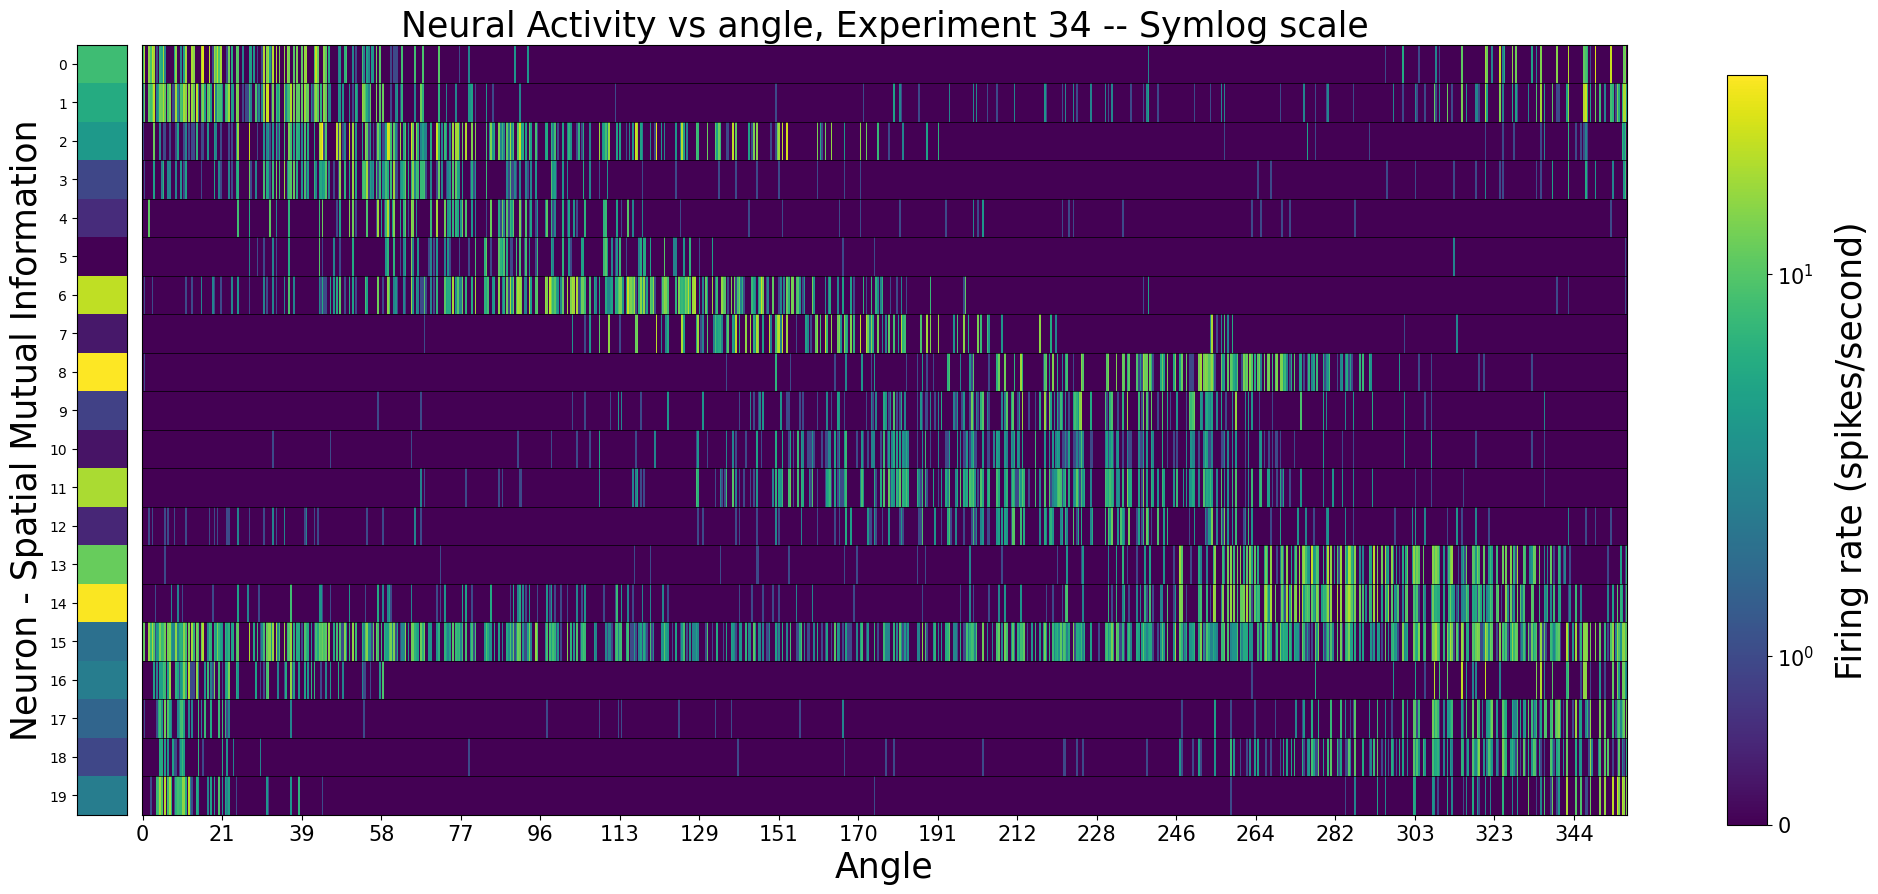

In [71]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = mi_thresh_spatial_mutual_info[com_sort]

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(mi_thresh_spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(organized_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_mi_thresh_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

## Run PCA

Find the eigenspectrum. How does it decay? --> Is the neural manifold "Smooth"?

See: https://www.nature.com/articles/s41586-019-1346-5

## Train Decoder FFNN

In [72]:
neural_activity.shape

(934, 40)

In [108]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set a fixed random seed for reproducibility
torch.manual_seed(0)


input_dim = neural_activity.shape[1]

# Define a simple feedforward neural network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50).float()  # First hidden layer
        self.fc2 = nn.Linear(50, 20).float()  # Second hidden layer
        self.fc3 = nn.Linear(20, 2).float()  # Output layer

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # No activation function after final layer (for regression task)
        return x

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [109]:
# Create an instance of the network
decoder = Decoder().to(device)

# Use mean squared error loss for regression
criterion = nn.MSELoss()

# use adam optimizer
optimizer = optim.Adam(decoder.parameters(), lr=0.01)

In [100]:
# Assume we have some training data in input_data (100-dimensional input) and target_data (2-dimensional output)
input_data = torch.from_numpy(neural_activity).float().to(device)
target_data = torch.from_numpy(np.array(angles)).float().to(device)

# Split data into training and validation sets (80-20 split)
train_size = int(0.8 * len(input_data))
val_size = len(input_data) - train_size

train_data = TensorDataset(input_data[:train_size], target_data[:train_size])
val_data = TensorDataset(input_data[train_size:], target_data[train_size:])

# Create DataLoaders from your datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [110]:
# Arrays to keep track of losses
train_losses = []
val_losses = []


# Train the network
for epoch in range(100):  # Loop over the dataset multiple times
    # Training phase
    decoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss}")

    # Validation phase
    decoder.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, targets in val_loader:
            outputs = decoder(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

        epoch_loss = running_loss / len(val_loader)
        val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}")

print('Finished Training')

RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 1

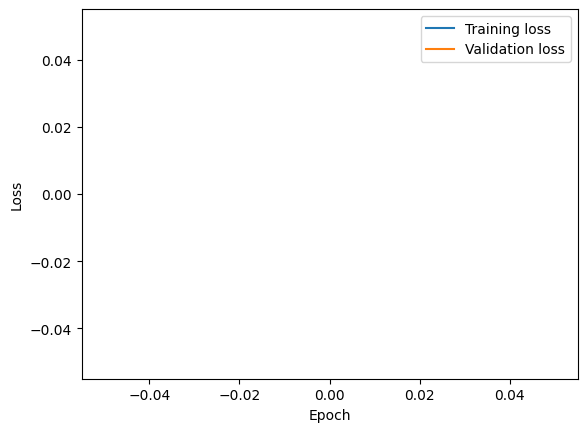

In [111]:
# Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()